# $\mathsf{PyFilConnect}$ code

### Import standard Python packages

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import division
import sys
import matplotlib.pyplot as plt
import numpy as np

## Preparing halo file for DisPerSE filament finder

### Loading halo catalogue at z=1

In [2]:
X=np.loadtxt('HaloMSM/GD512PXZ1.dat')
Y=np.loadtxt('HaloMSM/GD512PYZ1.dat')
Z=np.loadtxt('HaloMSM/GD512PZZ1.dat')
M=np.loadtxt('HaloMSM/GD512MZ1.dat') 
Rv=np.loadtxt('HaloMSM/GD512RvZ1.dat')

### Creating initial conditions for DisPerSE

In [3]:
Boxsize=302.627
littleh=0.6774

x1 = np.array(X/(Boxsize*1e3) +0.5) #normalize our box to 1
y1 = np.array(Y/(Boxsize*1e3) +0.5)
z1 = np.array(Z/(Boxsize*1e3) +0.5)
M1 = np.array(M/littleh) # virial mass
r1 = np.array(Rv/(Boxsize*1e3)) # virial radius

data=np.column_stack([x1,y1,z1])

n_dim = 3
n_part = len(x1)
print('number of halos =',n_part)

np.savetxt('HaloGD512Z1.txt',data,header='ANDFIELD COORDS \n['+str(n_dim)+' '+str(n_part)+']',comments='')
print('Creation of DisPerSE initial file')

data=np.column_stack([M1])

n_part = len(x1)

np.savetxt('HaloGD512Z1_weight.txt',data,header='ANDFIELD \n['+str(n_part)+']',comments='')
print('Creation of DisPerSE weight file')


number of halos = 26468
Creation of DisPerSE initial file
Creation of DisPerSE weight file


## Running DisPerSE on a cluster

### Run the Delaunay tessellation on the particle data

In [4]:
#File iniDisperseH => delaunay_3D

#delaunay_3D HaloGD512Z1.txt -btype periodic -outDir ./

#it will generate the file HaloGD512Z1.txt.NDnet

### Weight the tesselation by a given field

In [5]:
############## Weight the tesselation

#netconv HaloGD512Z1.txt.NDnet -to NDnet_ascii -outDir ./

#This creates HaloGD512Z1.txt.NDnet.a.NDnet


In [6]:
###### Create the weighting file
import read_dtfe_dev_v2

#idf you use numpy >=1.24
np.float=float
np.int = int
np.object = object
np.bool = bool

read_dtfe_dev_v2.FILE4WEIGHTING('DisPerSEoutput/HaloGD512Z1.txt.NDnet.a.NDnet','HaloGD512Z1_weight_out.txt' ,'HaloGD512Z1_weight.txt','HaloGD512Z1.txt')

version of feb, 3, 2023
tesselation read
there are more vertices than halos. It is ok


In [7]:
############## Weight the tesselation

#netconv HaloGD512Z1.txt.NDnet -addField HaloGD512Z1_weight_out.txt field_value

#This creates HaloGD512Z1.txt.NDnet.NDnet

# See file runDisperseH => mse

#mse HaloGD512Z1.txt.NDnet.NDnet -upSkl -outDir ./ -periodicity 1 -nsig (from 1 to 8) -forceLoops -nthreads 128

#This will create HaloGD512Z1.txt.NDnet_s(from 1 to 8).up.NDskl


In [8]:
############## Create skeleton

#module load disperse/0.9.24

#skelconv HaloGD512Z1.txt.NDnet_s(from 1 to 8).up.NDskl -breakdown -to NDskl_ascii 

#Read data

#You get files HaloGD512Z1.txt.NDnet_s(from 1 to 8).up.NDskl.BRK.a.NDskl

## Extracting Critical Points from the cosmic web

In [9]:
# We ran DisPerSE for nsig=[1,2,3,4,5,6,7,8]

for kk in [1,2,3,4,5,6,7,8]:
	print(kk)
	skl_name = 'DisPerSEoutput/HaloGD512Z1.txt.NDnet.NDnet_s{}.up.NDskl.BRK.a.NDskl'.format(kk)
	skl_ = read_dtfe_dev_v2.ReadSKL(skl_name)
    
	Ngo = skl_.NFIL

	Type=skl_.CPtype

	sol=np.where(Type>2.5)[0]

	xCP=skl_.CPposs[0][sol]
	yCP=skl_.CPposs[1][sol]
	zCP=skl_.CPposs[2][sol]

	xCP=xCP
	yCP=yCP
	zCP=zCP

	np.savetxt('CP/CPGD512HZ1Sig{}.txt'.format(kk),[xCP,yCP,zCP]) 

print('CPs saved')


1
2
3
4
5
6
7
8
CPs saved


### Finding the best match between CPs and halos with M_vir > 1e13 Msol

In [10]:
#Preparing data for the study
solCluster=np.where(M1>=1e13)

x1c = x1[solCluster]
y1c = y1[solCluster]
z1c = z1[solCluster]
r1c = r1[solCluster]

1
Fraction of halos with at least one associated critical point: 35.42%
Fraction of critical points with at least one associated halo: 20.97%
2
Fraction of halos with at least one associated critical point: 26.42%
Fraction of critical points with at least one associated halo: 19.88%
3
Fraction of halos with at least one associated critical point: 17.07%
Fraction of critical points with at least one associated halo: 16.10%
4
Fraction of halos with at least one associated critical point: 9.62%
Fraction of critical points with at least one associated halo: 10.99%
5
Fraction of halos with at least one associated critical point: 4.68%
Fraction of critical points with at least one associated halo: 8.08%
6
Fraction of halos with at least one associated critical point: 2.15%
Fraction of critical points with at least one associated halo: 7.19%
7
Fraction of halos with at least one associated critical point: 1.02%
Fraction of critical points with at least one associated halo: 8.14%
8
Fraction of

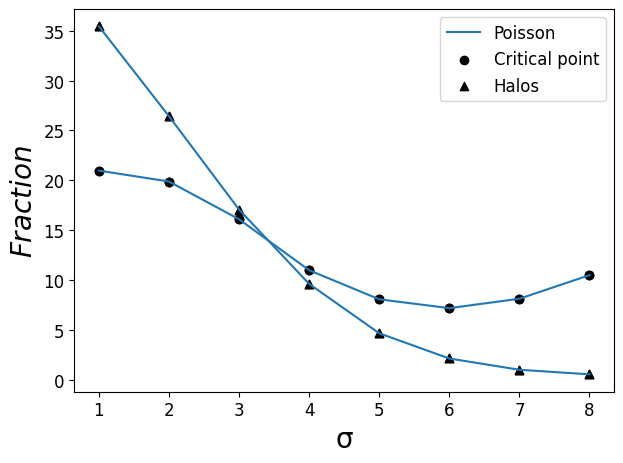

In [11]:
plt.rcParams['font.size']=12

Xax=[]
Yax1=[]
Yax2=[]

for kk in [1,2,3,4,5,6,7,8]:
	print(kk)
	CP=np.loadtxt('CP/CPGD512HZ1Sig{}.txt'.format(kk))
	CPx=CP[0]
	CPy=CP[1]
	CPz=CP[2]

	xhalos = x1c[:, np.newaxis, np.newaxis]
	yhalos = y1c[:, np.newaxis, np.newaxis]
	zhalos = z1c[:, np.newaxis, np.newaxis]

	CPx = CPx[np.newaxis, :, np.newaxis]
	CPy = CPy[np.newaxis, :, np.newaxis]
	CPz = CPz[np.newaxis, :, np.newaxis]

	minhalo = np.sqrt((CPx - xhalos)**2 + (CPy - yhalos)**2 + (CPz - zhalos)**2)

	associated_critical_points = np.empty_like(x1c, dtype=np.intp)
	associated_critical_points.fill(-1)  # Initialize with an invalid value

	# Initialize an empty list for each critical point
	associated_halos_for_critical_points = [[] for _ in range(len(CPx))]

	for ii in range(len(x1c)):
		eligible_critical_points = np.where(minhalo[ii] <= r1c[ii])[0]

		if len(eligible_critical_points) > 0:
			closest_critical_point = eligible_critical_points[np.argmin(minhalo[ii, eligible_critical_points])]
			associated_critical_points[ii] = closest_critical_point

		# Dynamically extend the list if needed
			while closest_critical_point >= len(associated_halos_for_critical_points):
				associated_halos_for_critical_points.append([])

		# Keep track of associated halos for each critical point
			associated_halos_for_critical_points[closest_critical_point].append(ii)
		else:
			continue

	# Calculate the fraction of halos with at least one associated critical point
	f1 = np.count_nonzero(associated_critical_points != -1) / len(x1c)
	print(f"Fraction of halos with at least one associated critical point: {f1:.2%}")

	# Calculate the fraction of critical points with at least one associated halo
	total_critical_points = len(associated_halos_for_critical_points)
	f2 = np.count_nonzero([len(assoc_halos) > 0 for assoc_halos in associated_halos_for_critical_points]) / total_critical_points

	print(f"Fraction of critical points with at least one associated halo: {f2:.2%}")

	Xax.append(kk)
	Yax1.append(f1*100)
	Yax2.append(f2*100)

#np.savetxt('FracPOZ1.txt',[Xax,Yax1,Yax2]) 

ratios = [yy1 / yy2 for yy1, yy2 in zip(Yax1, Yax2)]
differences = [abs(ratio - 1) for ratio in ratios]

min_diff_index = differences.index(min(differences))

closest_Xax_value = Xax[min_diff_index]

print(f"the best sigma value is: {closest_Xax_value}")


plt.plot(Xax,Yax1,color='C0',label='Poisson')
plt.plot(Xax,Yax2,color='C0')

plt.scatter(Xax,Yax2,color='k',marker='o')
plt.scatter(Xax,Yax1,color='k',marker='^')


plt.scatter(Xax,Yax2,color='k',marker='o',label='Critical point')
plt.scatter(Xax,Yax1,color='k',marker='^',label='Halos')

plt.xlabel(r"$\mathrm{\sigma}$",fontsize=20)
plt.ylabel(r'$Fraction$',fontsize=20)
plt.tight_layout()
plt.legend()
plt.show()

#plt.savefig('FractionHZ1.pdf')
#plt.close()

## Finding the extremum coordinates of filaments

In [12]:
for kk in [1,2,3,4,5,6,7,8]:
	print(kk)
	xx1, yy1, zz1 = [], [], []
	xx2, yy2, zz2 = [], [], []

	skl_name = 'DisPerSEoutput/HaloGD512Z1.txt.NDnet.NDnet_s{}.up.NDskl.BRK.a.NDskl'.format(kk)
	skl_ = read_dtfe_dev_v2.ReadSKL(skl_name)

	Ngo = skl_.NFIL

	for k in range(Ngo):
		xx = skl_.FILpos[:, 0, k]
		yy = skl_.FILpos[:, 1, k]
		zz = skl_.FILpos[:, 2, k]

		w = np.where(xx > 0)[0]


		for iseg in range(len(xx[w]) - 1):
			xx1.append(xx[w][iseg])
			xx2.append(xx[w][iseg + 1])
			yy1.append(yy[w][iseg])
			yy2.append(yy[w][iseg + 1])
			zz1.append(zz[w][iseg])
			zz2.append(zz[w][iseg + 1])
		
		
	     
	np.savetxt('Filament/R1bGD512HZ1Sig{}.txt'.format(kk),[xx1,yy1,zz1])
	np.savetxt('Filament/R1eGD512HZ1Sig{}.txt'.format(kk),[xx2,yy2,zz2]) 

print('Filament positions saved')


1
2
3
4
5
6
7
8
Filament positions saved


## Computing the connectivity

In [13]:
x1 = np.array(X/(Boxsize*1e3) +0.5) #normalize our box to 1
y1 = np.array(Y/(Boxsize*1e3) +0.5)
z1 = np.array(Z/(Boxsize*1e3) +0.5)
r1 = np.array(Rv/(Boxsize*1e3)) # virial radius

for kkkk in [1,2,3,4,5,6,7,8]:
    R1bA=np.loadtxt('Filament/R1bGD512HZ1Sig{}.txt'.format(kkkk))
    R1eA=np.loadtxt('Filament/R1eGD512HZ1Sig{}.txt'.format(kkkk))
    
    
    r1bx=R1bA[0]
    r1by=R1bA[1]
    r1bz=R1bA[2]
    
    r1ex=R1eA[0]
    r1ey=R1eA[1]
    r1ez=R1eA[2]
    
    #alpha=1.5 # corresponds to 1.5 virial radius
    alpha=[1.5,1,2]
    
    for jj in range(0,len(alpha),1):
        print(kkkk,jj)
        Kon=[]            
        for kk in range(0,len(r1),1):
            R1b = np.sqrt((r1bx-x1[kk])**2 + (r1by-y1[kk])**2 + (r1bz-z1[kk])**2)
            R1e = np.sqrt((r1ex-x1[kk])**2 + (r1ey-y1[kk])**2 + (r1ez-z1[kk])**2)
            
            
            K2=np.where((R1b <= alpha[jj]*r1[kk])*(R1e >= alpha[jj]*r1[kk]))[0]
            K1=np.where((R1e <= alpha[jj]*r1[kk])*(R1b >= alpha[jj]*r1[kk]))[0]
            
            #print(len(K1)+len(K2))
            Kon.append(len(K1)+len(K2))

        print(len(Kon),len(M1))
        np.savetxt('Connectivity/Con512HZ1AllSig{}A{}.txt'.format(kkkk,jj),np.array([M1,Kon])) 


1 0
26468 26468
1 1
26468 26468
1 2
26468 26468
2 0
26468 26468
2 1
26468 26468
2 2
26468 26468
3 0
26468 26468
3 1
26468 26468
3 2
26468 26468
4 0
26468 26468
4 1
26468 26468
4 2
26468 26468
5 0
26468 26468
5 1
26468 26468
5 2
26468 26468
6 0
26468 26468
6 1
26468 26468
6 2
26468 26468
7 0
26468 26468
7 1
26468 26468
7 2
26468 26468
8 0
26468 26468
8 1
26468 26468
8 2
26468 26468


## Plotting the connectivity for r < 1.5 r_vir 

1
2
3
4
5
6
7
8


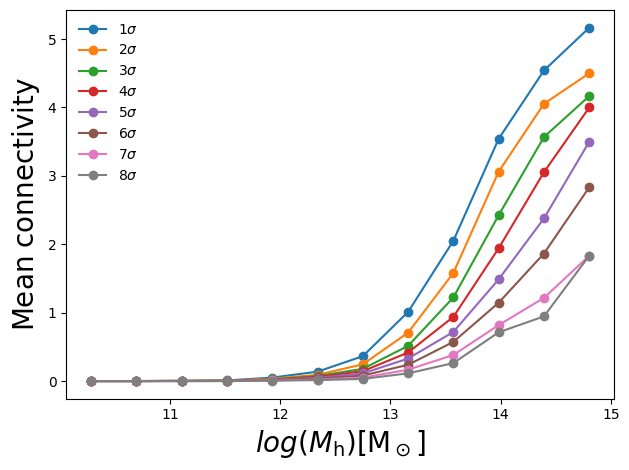

In [14]:
plt.rcParams['font.size']=10

for kk in [1,2,3,4,5,6,7,8]:
	print(kk)
###################################################################################################################
	A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A0.txt'.format(kk))

	x_values = np.array(A[0])
	y_values = np.array(A[1])
	x_values = np.log10(x_values)

	num_bins = 12

	# Calculate mean of y for each bin
	mean_values, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
	std_values, _ = np.histogram(x_values, bins=num_bins, weights=y_values**2)  # squared to get variance
	variance = std_values - mean_values**2

	# Clip to ensure non-negative values before taking the square root
	std_values = np.sqrt(np.clip(variance, a_min=0, a_max=None))

	# Avoid division by zero
	bin_counts, _ = np.histogram(x_values, bins=num_bins)
	mean_values[bin_counts != 0] /= bin_counts[bin_counts != 0]

	# Plot the mean values along the x-axis with a log scale
	bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
	plt.plot(bin_centers, mean_values, marker='o', linestyle='-', label=r'${} \sigma $'.format(kk))


plt.legend(loc='upper left',frameon=False,ncol=1)

plt.ylabel(r"$\mathrm{Mean \; connectivity}$",fontsize=20)
plt.xlabel(r'$log(M_{\rm h})[\mathrm{M_\odot}]$',fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('ConAll512GDHZ1.pdf')
#plt.close()

## Plotting the connectivity for the best $3\mathsf{\sigma}$ with error-bar

26468
16 Maximum binning from Sturge criterion


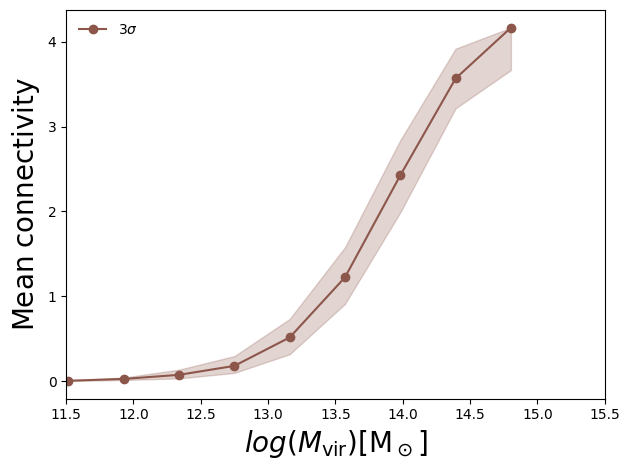

In [15]:
plt.rcParams['font.size']=10

kk=3

A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A0.txt'.format(kk))

x_values = np.array(A[0])
y_values = np.array(A[1])
x_values = np.log10(x_values)

data=x_values
print(len(data))
bins = int(np.ceil(np.log2(len(data)) + 1))
print(bins,'Maximum binning from Sturge criterion')

num_bins = 12

# Calculate mean of y for each bin
mean_values, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
std_values, _ = np.histogram(x_values, bins=num_bins, weights=y_values**2)  # squared to get variance
variance = std_values - mean_values**2

# Clip to ensure non-negative values before taking the square root
std_values = np.sqrt(np.clip(variance, a_min=0, a_max=None))

# Avoid division by zero
bin_counts, _ = np.histogram(x_values, bins=num_bins)
mean_values[bin_counts != 0] /= bin_counts[bin_counts != 0]

# Plot the mean values along the x-axis with a log scale
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, mean_values, marker='o', linestyle='-', label=r'$3 \sigma $',color='C5')


A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A1.txt'.format(kk))

x_values = np.array(A[0])
y_values = np.array(A[1])
x_values = np.log10(x_values)

# Calculate mean of y for each bin
mean_values1, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)

# Avoid division by zero
bin_counts, _ = np.histogram(x_values, bins=num_bins)
mean_values1[bin_counts != 0] /= bin_counts[bin_counts != 0]


A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A2.txt'.format(kk))

x_values = np.array(A[0])
y_values = np.array(A[1])
x_values = np.log10(x_values)

# Calculate mean of y for each bin
mean_values2, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)

# Avoid division by zero
bin_counts, _ = np.histogram(x_values, bins=num_bins)
mean_values2[bin_counts != 0] /= bin_counts[bin_counts != 0]

upper_bounds = np.maximum.reduce([mean_values, mean_values1, mean_values2])
lower_bounds = np.minimum.reduce([mean_values, mean_values1, mean_values2])


plt.fill_between(bin_centers,lower_bounds, upper_bounds, alpha=.25,color='C5')
plt.xlim(11.5,15.5)

plt.legend(loc='upper left',frameon=False,ncol=1)

plt.ylabel(r"$\mathrm{Mean \; connectivity}$",fontsize=20)
plt.xlabel(r'$log(M_{\rm vir})[\mathrm{M_\odot}]$',fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('ConAll512BestMatchHZ2.pdf')
#plt.close()

## Computing the connectivity slope

1
1.7989626907993261
2
2.1161581098118956
3
1.8425450595817545
4
2.1165213283320075
5
1.8524236643953624


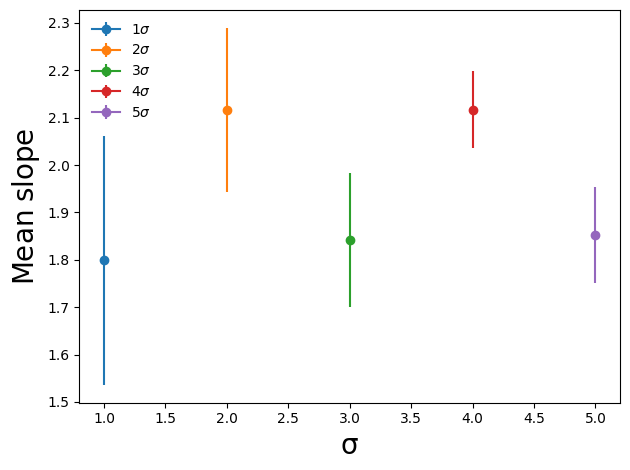

In [16]:
plt.rcParams['font.size']=10

for kk in [1,2,3,4,5]:
    print(kk)
    ###################################################################################################################
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A0.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
      
    num_bins = 12
    
    # Calculate mean of y for each bin
    mean_values, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    std_values, _ = np.histogram(x_values, bins=num_bins, weights=y_values**2)  # squared to get variance
    variance = std_values - mean_values**2
    
    # Clip to ensure non-negative values before taking the square root
    std_values = np.sqrt(np.clip(variance, a_min=0, a_max=None))
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    # Plot the mean values along the x-axis with a log scale
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2    
    
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A1.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
    
    # Calculate mean of y for each bin
    mean_values1, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values1[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A2.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
    
    # Calculate mean of y for each bin
    mean_values2, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values2[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    upper_bounds = np.maximum.reduce([mean_values, mean_values1, mean_values2])
    lower_bounds = np.minimum.reduce([mean_values, mean_values1, mean_values2])
    
    
    ymax=np.array(upper_bounds)
    ymin=np.array(lower_bounds)
    ymoy=(ymax+ymin)/2
    y_err2 = np.mean(np.vstack([ymoy - ymin, ymax - ymoy]), axis=0)
    
    
    x,y,y_err=bin_centers,ymoy, y_err2
    
    #plt.scatter(x,y)
    
    dy = np.diff(y)
    
    # Find the index where the slope significantly increases
    threshold_slope_change = 0.1
    breakpoint_index = np.argmax(np.abs(dy) > threshold_slope_change)
    
    # Calculate the slope only after the breaking point
    y=y[breakpoint_index+1:] 
    x=x[breakpoint_index+1:]
    y_err=y_err[breakpoint_index+1:]
    
    
    coefficients, cov_matrix = np.polyfit(x,y, 1, w=1/y_err, cov=True)
    
    # Extract slope and standard error of the slope
    slope_after_breakpoint = coefficients[0]
    stderr_slope_after_breakpoint = np.sqrt(np.diag(cov_matrix))[0]
    
    # Calculate the average slope with error
    average_slope_after_breakpoint = slope_after_breakpoint
    average_stderr_slope_after_breakpoint = stderr_slope_after_breakpoint
    
    print(average_slope_after_breakpoint)
    
    
    plt.errorbar(kk, average_slope_after_breakpoint, yerr=average_stderr_slope_after_breakpoint,marker='o',label=r'${} \sigma $'.format(kk))


plt.legend(loc='upper left',frameon=False,ncol=1)

plt.ylabel(r"$\mathrm{Mean \; slope}$",fontsize=20)
plt.xlabel(r"$\mathrm{\sigma}$",fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('ConAll512GDHZ1.pdf')
#plt.close()

## Computing the connectivity offset at M_vir = 1e14 Msol

1
2
3
4
5


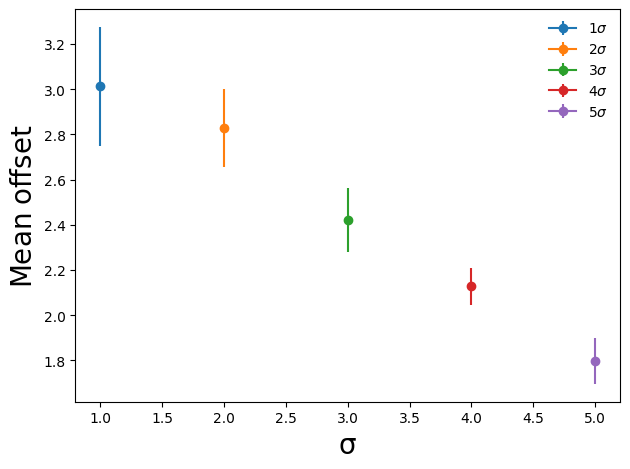

In [17]:
plt.rcParams['font.size']=10

for kk in [1,2,3,4,5]:
    print(kk)
    ###################################################################################################################
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A0.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
      
    num_bins = 12
    
    # Calculate mean of y for each bin
    mean_values, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    std_values, _ = np.histogram(x_values, bins=num_bins, weights=y_values**2)  # squared to get variance
    variance = std_values - mean_values**2
    
    # Clip to ensure non-negative values before taking the square root
    std_values = np.sqrt(np.clip(variance, a_min=0, a_max=None))
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    # Plot the mean values along the x-axis with a log scale
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2    
    
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A1.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
    
    # Calculate mean of y for each bin
    mean_values1, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values1[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    
    A=np.loadtxt('Connectivity/Con512HZ1AllSig{}A2.txt'.format(kk))
    
    x_values = np.array(A[0])
    y_values = np.array(A[1])
    x_values = np.log10(x_values)
    
    # Calculate mean of y for each bin
    mean_values2, bin_edges = np.histogram(x_values, bins=num_bins, weights=y_values)
    
    # Avoid division by zero
    bin_counts, _ = np.histogram(x_values, bins=num_bins)
    mean_values2[bin_counts != 0] /= bin_counts[bin_counts != 0]
    
    upper_bounds = np.maximum.reduce([mean_values, mean_values1, mean_values2])
    lower_bounds = np.minimum.reduce([mean_values, mean_values1, mean_values2])
    
    
    ymax=np.array(upper_bounds)
    ymin=np.array(lower_bounds)
    ymoy=(ymax+ymin)/2
    y_err2 = np.mean(np.vstack([ymoy - ymin, ymax - ymoy]), axis=0)
    
    
    x,y,y_err=bin_centers,ymoy, y_err2
    
    #plt.scatter(x,y)
    
    dy = np.diff(y)
    
    # Find the index where the slope significantly increases
    threshold_slope_change = 0.1
    breakpoint_index = np.argmax(np.abs(dy) > threshold_slope_change)
    
    # Calculate the slope only after the breaking point
    y=y[breakpoint_index+1:] 
    x=x[breakpoint_index+1:]
    y_err=y_err[breakpoint_index+1:]
    
    
    coefficients, cov_matrix = np.polyfit(x,y, 1, w=1/y_err, cov=True)
    
    # Extract slope and standard error of the slope
    poly = np.poly1d(coefficients)
    
    # Valeur spécifique à laquelle vous voulez évaluer le fit
    x_specifique = 14
    
    # Calcul de la valeur prédite
    stderr_slope_after_breakpoint = np.sqrt(np.diag(cov_matrix))[0]
    
    # Calculate the average slope with error
    average_slope_after_breakpoint = poly(x_specifique)
    average_stderr_slope_after_breakpoint = stderr_slope_after_breakpoint
    
    plt.errorbar(kk, average_slope_after_breakpoint, yerr=average_stderr_slope_after_breakpoint,marker='o',label=r'${} \sigma $'.format(kk))


plt.legend(loc='upper right',frameon=False,ncol=1)

plt.ylabel(r"$\mathrm{Mean \; offset}$",fontsize=20)
plt.xlabel(r"$\mathrm{\sigma}$",fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('ConAll512GDHZ1.pdf')
#plt.close()